In [1]:
#!python3
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

def make_dir(dir_name):
	"""
	A function that creates a directory dir_name, if it doesn't exist.
	"""
	path = dir_name
	try:
		os.mkdir(path)
	except FileExistsError:
		print(f"Director {path} already exists")
	except OSError:
		print (f"Creation of the directory %s failed" % path)
	else:
		print ("Successfully created the directory %s " % path)

def fourier_spectrum(X, sample_freq=1e-3):
	"""
	Returns the power spectrum (in arbitary units) for a given
	signal X and a sampling frequency sample_freq
	"""
	# find FFT of signal and its amplitude
	ps = np.abs(np.fft.fft(X))**2 
	# store frequencies and indices corresponding to the above FFT
	freqs = np.fft.fftfreq(X.size, sample_freq)
	idx = np.argsort(freqs)

	return (freqs[idx], ps[idx])

def signaltonoise(fs, ps, f_d):
	"""
	Returns the signal to noise ratio in dB for a given range of frequencies
	fs for a powerspectrum ps, specifically for a given frequency
	"""

	# find the index of the specified frequency
	idx = np.where(fs==f_d) 
	# find the value of the spectrum at that frequency
	signal = ps[idx]

	# removing edge cases of when the indices are at the edge
	# of the spectrum
	if idx==0:
		return 0
	elif idx==len(fs):
		return 0

	# calculating noise by averaging/interpolating
	# the neighbouring spectral values from the 
	# specified frequency
	noise = (1/2)*(ps[idx-1] + ps[idx+1])

	return 10*np.log10(signal/noise)

def residence_time(x,flags=1.0):
	"""
	Returns the residence time distribution for a given signal x
	and for a given set of flags (where the timekeeping is triggered)
	"""

	# measure the time between it going between +flag and -flag
	# and add it to an array
	# return the array and/or produce a historgram so it also
	# gives you the distribution
	steps = len(x)

	# keeping track of the crossing indices, * being the null label
	crossing_indices = np.array([(0,"*")])

	tol = 1e-3 # tolerance for when signal crosses the flag

	dt = 1e-3 # took this value from the simulator

	for i in range(steps):
		if x[i] == 0:
			continue
		if (np.abs(x[i]-flags) < tol) and (x[i]-x[i-1] > 0):
			# this is when the signal is breaching the positive crossing
			if len(crossing_indices) > 1:
				# if this isn't the first time a crossing occured
				if crossing_indices[-1][-1] == "-":
					# and if the last crossing was at the other
					# level crossing
					crossing_indices = np.vstack((crossing_indices,[(i,"+")]))
					# append this to the new crossing
			else:
				crossing_indices = np.vstack((crossing_indices,[(i,"+")]))
			# otherwise, ignore completely
		elif (np.abs(x[i]+flags) < tol) and (x[i]-x[i-1] < 0):
			# this is the negative crossing
			if len(crossing_indices) > 1:
				# if this isn't the first time a crossing occured
				if crossing_indices[-1][-1] == "+":
					# and if the last crossing was at the other
					# level crossing
					crossing_indices = np.vstack((crossing_indices,[(i,"-")]))
					# append this to the new crossing
			else:
				crossing_indices = np.vstack((crossing_indices,[(i,"-")]))
			# otherwise, ignore completely


	crossing_indices = crossing_indices[1:] # ignoring the first crossing index since it's (0,*)
	rtseries = np.array([dt*int(i) for i,_ in crossing_indices])

	# setting the first crossing to t=0
	rtseries = rtseries-rtseries[0]

	# finding the distribution by subtracting from an offset timing series
	rtdistribution = rtseries[1:] - rtseries[:-1]

	# returns the indices when the flags were triggered, the timing series and the distribution overall
	return (crossing_indices, rtseries, rtdistribution)

def histogram_movie(data_loc, resolution, plot_loc):
	"""
	A function that returns a directory of images
	depicting the probability density (histogram)
	of the positions for each time step that can be
	made into a movie.
		data_loc : directory where the simulated data is located
		resolution : number of bins for the histogram
		plot_loc : directory where the plots will be placed
	"""

	# making a list of all the files
	file_list = glob.glob(f"{data_loc}/experiment*")
	# importing all of the data from the experiments
	print("Importing data...")
	all_data = np.array([np.load(file) for file in file_list])
	# extracting time series (assumes common time scaling across exps)
	ts = all_data[0][0]
	# extracting all position datadata_lo
	pos_data = np.array([all_data[i][1] for i in range(len(all_data))])

	print("Producing plots...")
	# making histogram plots
	
	# creating a folder to save the plots
	make_dir(plot_loc)

	for i in range(len(ts)):
		print(f"\r{i}/{len(ts)}",end="")
		plt.clf() # clear figure
		plt.xlim(-1.5,1.5) # setting common x axis
		# we are taking the histogram across experiments
		# for each timestep, hence the transposing
		plt.hist(pos_data.T[i],bins=resolution,range=(-1.0,1.0)) # plotting histogram
		plt.title(f"Time : {ts[i]} units") # keeping track of time
		plt.savefig(f"./{plot_loc}/step-{i:05n}.png")
	print("\nPlot production complete!")
	# the plots then can be made into a movie to see the development
	# of the histograms using (requires FFMPEG)
	#	ffmpeg -framerate 24 -i step-%05d.png output.mp4

def velocity_distribution(data_loc, resolution, plot_loc):
	"""
		A function that shows the distribution of velocities and superimposes the predicted Maxwell-Boltzmann distribution
		WARNING : INCOMPLETE
	"""
	file_list = glob.glob(f"{data_loc}/experiment*")
	# importing all of the data from the experiments
	print("Importing data...")
	all_data = np.array([np.load(file) for file in file_list])
	# extracting time series (assumes common time scaling across exps)
	ts = all_data[0][0]
	# extracting all velocity data
	vel_data = np.array([all_data[i][3] for i in range(len(all_data))])
	print("Producing plots...")
	# plotting the histogram velocities
	plt.hist(vel_data, resolution)
	plt.title("Velocity distribution")
	plt.xlabel("Velocities")
	plt.savefig(f"{plot_loc}/vel-distribution.png")
	plt.show()

def energy_evolution(data_loc, plot_loc):
	"""
		A function that shows the evolution of the total
		energy of the system to see if something has gone wrong.
	"""
	file_list = glob.glob(f"{data_loc}/experiment*")
	# importing all of the data from the experiments
	print("Importing data...")
	all_data = np.array([np.load(file) for file in file_list])
	# extracting time series (assumes common time scaling across exps)
	ts = all_data[0][0]
	# extracting all kinetic energy
	kinetic_energy_data = np.array([all_data[i][3] for i in range(len(all_data))])
	potential_energy_data = np.array([all_data[i][4] for i in range(len(all_data))])

	# averaging the energies across the entire data set 
	# for each timestep
	kinetic_average = np.array([np.mean(kinetic_energy_data.T[i]) for i in range(len(ts))])
	potential_average = np.array([np.mean(potential_energy_data.T[i]) for i in range(len(ts))])
	total_average = kinetic_average + potential_average

	fig, axs = plt.subplots(3,1,sharex=True, sharey=True)
	# plotting the evolution of kinetic energy
	axs[0].plot(ts,kinetic_average,'ro-')
	axs[0].set_title("Kinetic")
	# plotting the evolution of potential energy
	axs[1].plot(ts,potential_average,'bo-')
	axs[1].set_title("Potential")
	# plotting the evolution of averge energy
	axs[2].plot(ts,total_average, 'go-')
	axs[2].set_title("Total Energy")

	# adding labels
	fig.suptitle("Energy evolution over time")
	plt.xlabel("Time [s]")
	plt.ylabel("Energy [J]")
	fig.savefig(f"{plot_loc}/energy-evolution.png")
	plt.show()

def energy_variance(data_loc, plot_loc):
	"""
		A function that returns a plot of how much the total energy varies with time
	"""
	file_list = glob.glob(f"{data_loc}/experiment*")
	# importing all of the data from the experiments
	print("Importing data...")
	all_data = np.array([np.load(file) for file in file_list])
	# extracting time series (assumes common time scaling across exps)
	ts = all_data[0][0]
	# extracting all energy data
	energy_data = np.array([all_data[i][3]+all_data[i][4] for i in range(len(all_data))])
	# averaging the energies across the entire data set 
	# for each timestep
	ensemble_average = np.array([np.mean(energy_data.T[i]) for i in range(len(ts))])

	var_ensemble = np.std(ensemble_average) # difference between each data point and its mean
	print(f"Variance of energies for current experiment : {var_ensemble}")
	plt.plot(ts, ensemble_average, label="Ensemble average")
	plt.plot(ts, np.abs(ensemble_average-np.mean(ensemble_average)), label="Variations from mean")

	plt.title("Energy evolution and variations over time")
	plt.xlabel("Time [s]")
	plt.ylabel("Energy [J}")
	plt.legend()
	plt.savefig(f"{plot_loc}/energy-profile.png")
	plt.show()

def signal_ensemble(data_loc,resolution,plot_loc):
	"""
	A function that returns heatmap of the position distributions
		data_loc : directory where the simulated data is located
		resolution : number of bins for the histogram
		plot_loc : directory where the plots will be placed
	"""
	# making a list of all the files
	file_list = glob.glob(f"{data_loc}/experiment*")
	# importing all of the data from the experiments
	print("Importing data...")
	all_data = np.array([np.load(file) for file in file_list])
	# extracting time series (assumes common time scaling across exps)
	ts = all_data[0][0]
	# extracting all position datadata_lo
	pos_data = np.array([all_data[i][1] for i in range(len(all_data))])

	print("Producing plots...")
	# making histogram plots
	
	# creating a folder to save the plots
	make_dir(plot_loc)

	# range of histogram will be experiment agnostic and is determined from the data directly

	amplitude = max(abs(pos_data[0]))*1.5# for starters

	ensemble_histogram = np.array([np.histogram(pos_data.T[i], bins=resolution, range=(-amplitude,amplitude))[0] for i in range(len(ts))])

	# A 2D matrix where each row is a histogram of position for each timestep

	# displaying the histogram

	fig, ax = plt.subplots(1,1) # just one picture
	ax.pcolor(ensemble_histogram.T) # such that x-axis is time and y-axis is position

	# relabeling axes
	
	# making the ticks correct
	# firstly, the xticks
	x_t_pos = np.linspace(0,len(ts),10) # we are sticking to just 10 ticks
	x_t_labels = [f"{t:.2f}" for t in ts[::len(ts)//10]] # choosing the right time values
	plt.xticks(x_t_pos, x_t_labels)	
	# now, the yticks
	y_t_pos = np.linspace(0,resolution,10)
	y_t_labels = [f"{x:.2E}" for x in np.linspace(-amplitude,amplitude,10)]
	plt.yticks(y_t_pos, y_t_labels)
	plt.xlabel("Time [s]")
	plt.ylabel("Position [m]")
	plt.title("Probability distribution of nanosphere across time")
	# always save figure before showing!!!
	plt.savefig(f"{plot_loc}/plot.png")
	plt.show()

In [88]:
data_loc = "../data_test"
resolution=100

# making a list of all the files
file_list = glob.glob(f"{data_loc}/experiment*")
# importing all of the data from the experiments
print("Importing data...")
all_data = np.array([np.load(file) for file in file_list])
# extracting time series (assumes common time scaling across exps)
ts = all_data[0][0]
# extracting all position datadata_lo
pos_data = np.array([all_data[i][1] for i in range(len(all_data))])

print("Producing plots...")
# making histogram plots

# creating a folder to save the plots
#make_dir(plot_loc)

# range of histogram will be experiment agnostic and is determined from the data directly

amplitude = max(abs(pos_data[0]))*1.5# for starters

ensemble_histogram = np.array([np.histogram(pos_data.T[i], bins=resolution, range=(-amplitude,amplitude), weights=np.ones_like(pos_data.T[i]) / len(pos_data.T[i]))[0] for i in range(len(ts))])

# A 2D matrix where each row is a histogram of position for each timestep

# displaying the histogram


Importing data...
Producing plots...


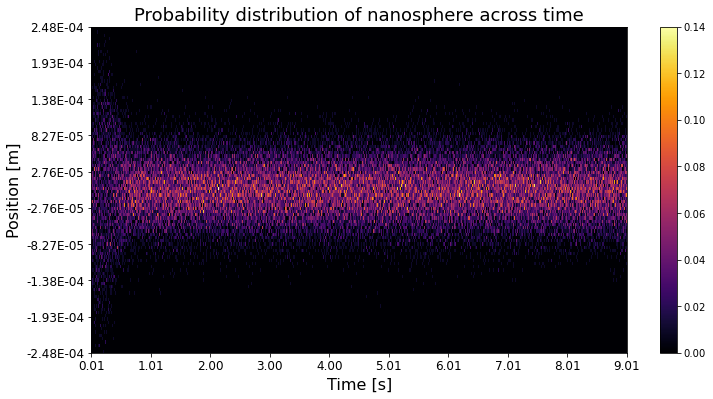

In [91]:
fig, ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(12)
hist = ax.pcolor(ensemble_histogram.T,cmap='inferno') # such that x-axis is time and y-axis is position
# adding colorbar
fig.colorbar(hist, ax=ax)
# relabeling axes

# making the ticks correct
# firstly, the xticks
x_t_pos = np.linspace(0,len(ts),10) # we are sticking to just 10 ticks
x_t_labels = [f"{t:.2f}" for t in ts[::len(ts)//10]] # choosing the right time values
ax.set_xticks(x_t_pos)
ax.set_xticklabels(x_t_labels,fontsize=12)
# now, the yticks
y_t_pos = np.linspace(0,resolution,10)
y_t_labels = [f"{x:.2E}" for x in np.linspace(-amplitude,amplitude,10)]
ax.set_yticks(y_t_pos)
ax.set_yticklabels(y_t_labels,fontsize=12)
ax.set_xlabel("Time [s]",fontsize=16)
ax.set_ylabel("Position [m]",fontsize=16)
ax.set_title("Probability distribution of nanosphere across time",fontsize=18)



# always save figure before showing!!!
plt.savefig("sample.png",bbox_inches='tight')


plt.show()


In [92]:
data_loc = "../data_test"

file_list = glob.glob(f"{data_loc}/experiment*")
# importing all of the data from the experiments
print("Importing data...")
all_data = np.array([np.load(file) for file in file_list])



Importing data...


In [84]:
ts,xs,vs,ks,ps = all_data[0]

ValueError: not enough values to unpack (expected 5, got 4)

In [93]:
# extracting time series (assumes common time scaling across exps)
ts = all_data[0][0]
# extracting all kinetic energy
kinetic_energy_data = np.array([all_data[i][3] for i in range(len(all_data))])
potential_energy_data = np.array([all_data[i][4] for i in range(len(all_data))])

# averaging the energies across the entire data set 
# for each timestep
kinetic_average = np.array([np.mean(kinetic_energy_data.T[i]) for i in range(len(ts))])
potential_average = np.array([np.mean(potential_energy_data.T[i]) for i in range(len(ts))])
total_average = kinetic_average + potential_average


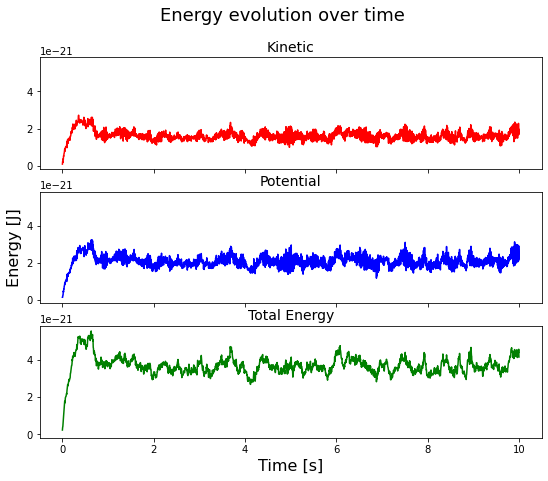

In [106]:
fig, axs = plt.subplots(3,1,sharex=True, sharey=True)
fig.set_figheight(7)
fig.set_figwidth(9)
# plotting the evolution of kinetic energy
axs[0].plot(ts,kinetic_average,'r-')
axs[0].set_title("Kinetic",fontsize=14)
# plotting the evolution of potential energy
axs[1].plot(ts,potential_average,'b-')
axs[1].set_title("Potential",fontsize=14)
# plotting the evolution of averge energy
axs[2].plot(ts,total_average, 'g-')
axs[2].set_title("Total Energy",fontsize=14)

# adding labels
fig.suptitle("Energy evolution over time", fontsize=18)
plt.xlabel("Time [s]",fontsize=16)
axs[1].set_ylabel("Energy [J]",fontsize=16)
#fig.savefig(f"{plot_loc}/energy-evolution.png")
plt.show()

In [107]:
data_loc = "../data_test"
file_list = glob.glob(f"{data_loc}/experiment*")
# importing all of the data from the experiments
print("Importing data...")
all_data = np.array([np.load(file) for file in file_list])
# extracting time series (assumes common time scaling across exps)
ts = all_data[0][0]
# extracting all energy data
energy_data = np.array([all_data[i][3]+all_data[i][4] for i in range(len(all_data))])
# averaging the energies across the entire data set 
# for each timestep
ensemble_average = np.array([np.mean(energy_data.T[i]) for i in range(len(ts))])

var_ensemble = np.std(ensemble_average) # difference between each data point and its mean
print(f"Variance of energies for current experiment : {var_ensemble}")


Importing data...
Variance of energies for current experiment : 4.989146687585895e-22


Importing data...
Mean of x = -3.721059116872697e-09m
Stdev of x = 4.283727883578847e-05m


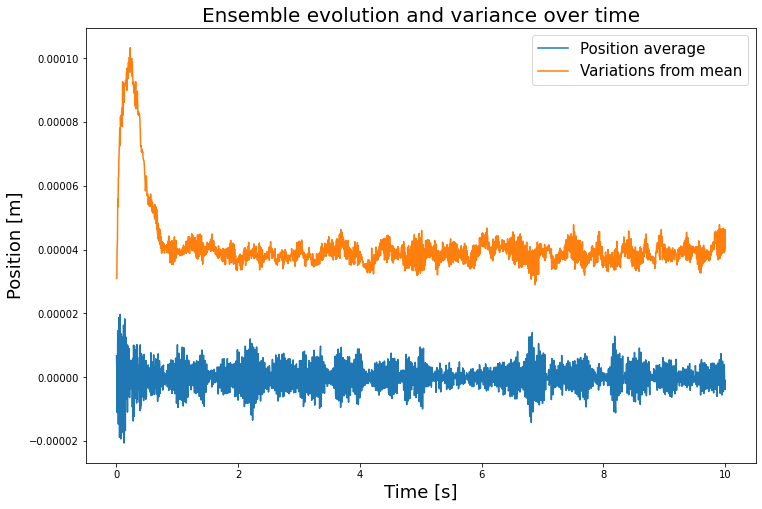

In [136]:
data_loc = "../data_test"
print("Importing data...")
all_data = np.array([np.load(file) for file in file_list])
# extracting time series (assumes common time scaling across exps)
ts = all_data[0][0]
# extracting all position data
pos_data = np.array([all_data[i][1] for i in range(len(all_data))])

pos_average = np.array([np.mean(pos_data.T[i]) for i in range(len(ts))])
pos_variance = np.array([np.std(pos_data.T[i]) for i in range(len(ts))])

print(f"Mean of x = {np.mean(pos_data)}m")
print(f"Stdev of x = {np.std(pos_data)}m")

fig, ax = plt.subplots(1)
fig.set_figheight(8)
fig.set_figwidth(12)

ax.plot(ts, pos_average, label="Position average")
ax.plot(ts, pos_variance, label="Variations from mean")

ax.set_title("Ensemble evolution and variance over time",fontsize=20)
ax.set_xlabel("Time [s]",fontsize=18)
ax.set_ylabel("Position [m]",fontsize=18)
ax.legend(fontsize=15)
#plt.savefig(f"{plot_loc}/signal-profile.png")
plt.show()

In [136]:
data_loc = "../data_tests/variable-stiffness"
resolution=100

In [137]:
file_list = glob.glob(f"{data_loc}/experiment*")
# importing all of the data from the experiments
print("Importing data...")
all_data = np.array([np.load(file) for file in file_list])
# extracting time series (assumes common time scaling across exps)
ts = all_data[0][0]
# extracting all velocity data
vel_data = np.array([all_data[i][2] for i in range(len(all_data))]).flatten()


Importing data...


In [138]:
rho = 1850
a = 71.5e-9
mass = rho*(4/3)*np.pi*a**3
kB = 1.38064852e-23
T = 300

Producing plots...


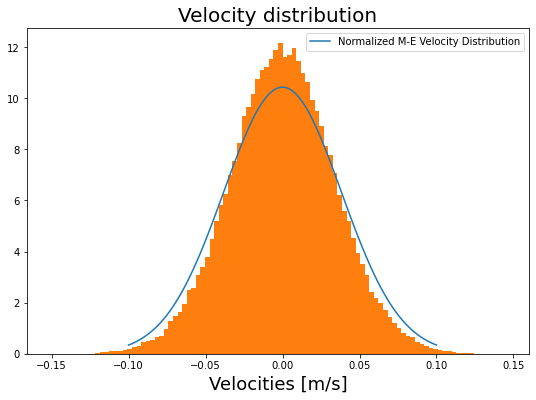

In [139]:
print("Producing plots...")
# plotting the histogram velocities
fig, ax = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(9)
vs = np.linspace(-0.1,0.1,100)
maxwell = np.exp(-0.5*mass*(vs**2)/(kB*T))
maxwell *= mass/np.sqrt(2*np.pi*mass*kB*T)
ax.plot(vs,maxwell,label="Normalized M-E Velocity Distribution")
x,bins,p = plt.hist(vel_data, resolution,density=True,stacked=True)
ax.set_title("Velocity distribution", fontsize=20)
ax.set_xlabel("Velocities [m/s]", fontsize=18)
ax.legend(loc='upper right')
#plt.savefig(f"{plot_loc}/vel-distribution.png")
plt.show()

In [56]:
print(mass)

2.8325557288725526e-18


In [71]:
len(vel_data[vel_data<0.1])

99900

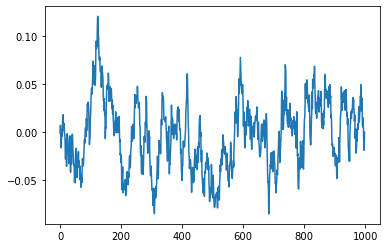

In [84]:
plt.plot(vel_data[0])

In [83]:
vel_data = np.array([all_data[i][2] for i in range(len(all_data))])